In [2]:
# --- import packages
import sys
sys.path.append("..")   # go up one directory so Python sees Librarian/

from Librarian.models import WorldDataset, CobbDouglasFit
from Librarian.config import REGION_PALETTE, REGION_NAME_MAP, INDICATORS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np



/Users/marcocella/PycharmProjects/Energy_poverty_/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Retriving data from 20+ years allow us to do single-cuontry analisys or comparison between few countries in the second part of the project. For this part we need only one year to compare all the nations, so we select it with the snapshot method.
Put it in a different block to save time during iterations.

In [3]:
# --- Load dataset
world = WorldDataset.from_api(INDICATORS, years=range(2000, 2023))



In [4]:
# --- Select 2022 snapshot
snapshot = world.snapshot(2021,
    dropna_cols=["life_expectancy",
                 "energy_use_per_capita",
                 "co2_per_capita"
                 ],)

# --- Add region names
snapshot = world.add_region_names(snapshot)
snapshot["region_name"] = snapshot["region"].map(REGION_NAME_MAP).fillna("Other")



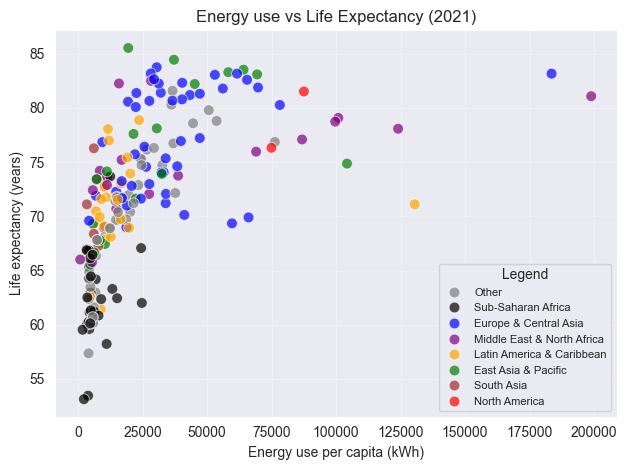

In [5]:
# --- Fit model
x = snapshot["energy_use_per_capita"]
y = snapshot["life_expectancy"]



# --- Plot
sns.scatterplot(
    data=snapshot,
    x="energy_use_per_capita",
    y="life_expectancy",
    hue="region_name",
    palette=REGION_PALETTE,
    s=60, #bubble dimentions
    alpha=0.7, #bubble trasparency
)

plt.grid(alpha=0.3)
plt.xlabel("Energy use per capita (kWh)")
plt.ylabel("Life expectancy (years)")
plt.title("Energy use vs Life Expectancy (2021)")
plt.legend(title="Legend", loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()



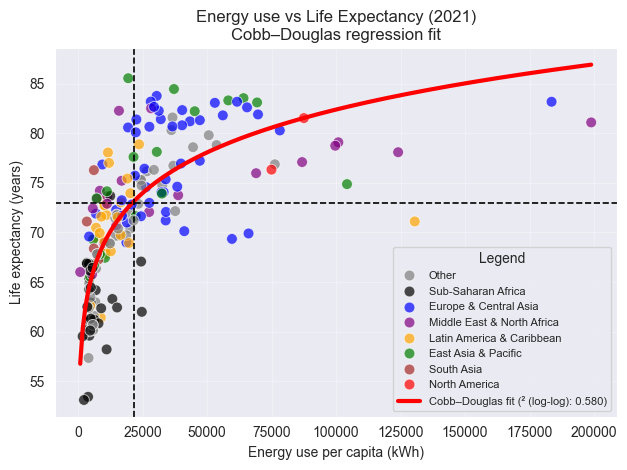

Fitted model: LifeExpectancy = 33.69 * EnergyUse^0.078


In [6]:
# --- Fit model
x = snapshot["energy_use_per_capita"]
y = snapshot["life_expectancy"]
fit = CobbDouglasFit.fit(x, y)
x_fit, y_fit = fit.curve(x.min(), x.max())



# --- Plot
sns.scatterplot(
    data=snapshot,
    x="energy_use_per_capita",
    y="life_expectancy",
    hue="region_name",
    palette=REGION_PALETTE,
    s=60, #bubble dimentions
    alpha=0.7, #bubble trasparency
)

plt.plot(x_fit, y_fit, color="red", linewidth=3, label=f"Cobb–Douglas fit (² (log-log): {fit.r2:.3f})")
plt.grid(alpha=0.3)
plt.axvline(21500, color="black", linestyle="--", linewidth=1.2)
plt.axhline(73, color="black", linestyle="--", linewidth=1.2)
plt.xlabel("Energy use per capita (kWh)")
plt.ylabel("Life expectancy (years)")
plt.title("Energy use vs Life Expectancy (2021)\nCobb–Douglas regression fit")
plt.legend(title="Legend", loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

print(f"Fitted model: LifeExpectancy = {fit.A:.2f} * EnergyUse^{fit.alpha:.3f}")


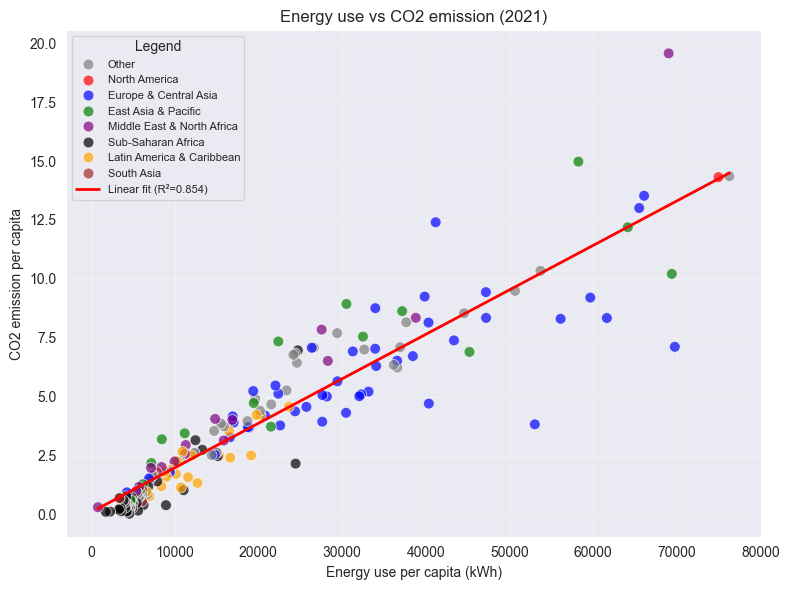

In [7]:

# --- Remove outliers
clean = snapshot.sort_values("energy_use_per_capita", ascending=False).iloc[10:].copy()
x = clean["energy_use_per_capita"].values.reshape(-1, 1) #reshape for linear regression
y = clean["co2_per_capita"].values

# --- Fit the model and compute r2
model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y, y_pred)

# --- Create regression line points
x_line = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
y_line = model.predict(x_line)

# --- Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=clean,
    x="energy_use_per_capita",
    y="co2_per_capita",
    hue="region_name",
    palette=REGION_PALETTE,
    s=60,
    alpha=0.7,
)

plt.plot(x_line, y_line, color="red", linewidth=2, label=f"Linear fit (R²={r2:.3f})")
plt.grid(alpha=0.3)
plt.xlabel("Energy use per capita (kWh)")
plt.ylabel("CO2 emission per capita")
plt.title("Energy use vs CO2 emission (2021)")
plt.legend(title="Legend", loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()

In [8]:
levels = [60, 65, 70, 75, 77, 78, 79, 80, 82, 83, 84]

for target in levels:
    subset = snapshot[snapshot["life_expectancy"] > target]

    # --- skip if no country matches the condition
    if subset.empty:
        print(f"\nNo countries with life expectancy > {target}")
        continue

    # --- minimum energy use among countries above this life expectancy
    thr = subset["energy_use_per_capita"].min()

    # --- country (or countries) that represent the threshold
    countries = subset[subset["energy_use_per_capita"] == thr]["name"].tolist()

    print(f"\nThreshold for life expectancy > {target}: {thr:.2f} kWh")
    print("Country/ies at this threshold:", ", ".join(countries))


Threshold for life expectancy > 60: 829.71 kWh
Country/ies at this threshold: Yemen, Rep.

Threshold for life expectancy > 65: 829.71 kWh
Country/ies at this threshold: Yemen, Rep.

Threshold for life expectancy > 70: 3401.63 kWh
Country/ies at this threshold: Bangladesh

Threshold for life expectancy > 75: 6130.37 kWh
Country/ies at this threshold: Sri Lanka

Threshold for life expectancy > 77: 11590.39 kWh
Country/ies at this threshold: Costa Rica

Threshold for life expectancy > 78: 11590.39 kWh
Country/ies at this threshold: Costa Rica

Threshold for life expectancy > 79: 15852.34 kWh
Country/ies at this threshold: Malta

Threshold for life expectancy > 80: 15852.34 kWh
Country/ies at this threshold: Malta

Threshold for life expectancy > 82: 15852.34 kWh
Country/ies at this threshold: Malta

Threshold for life expectancy > 83: 19441.07 kWh
Country/ies at this threshold: Hong Kong SAR, China

Threshold for life expectancy > 84: 19441.07 kWh
Country/ies at this threshold: Hong Kong

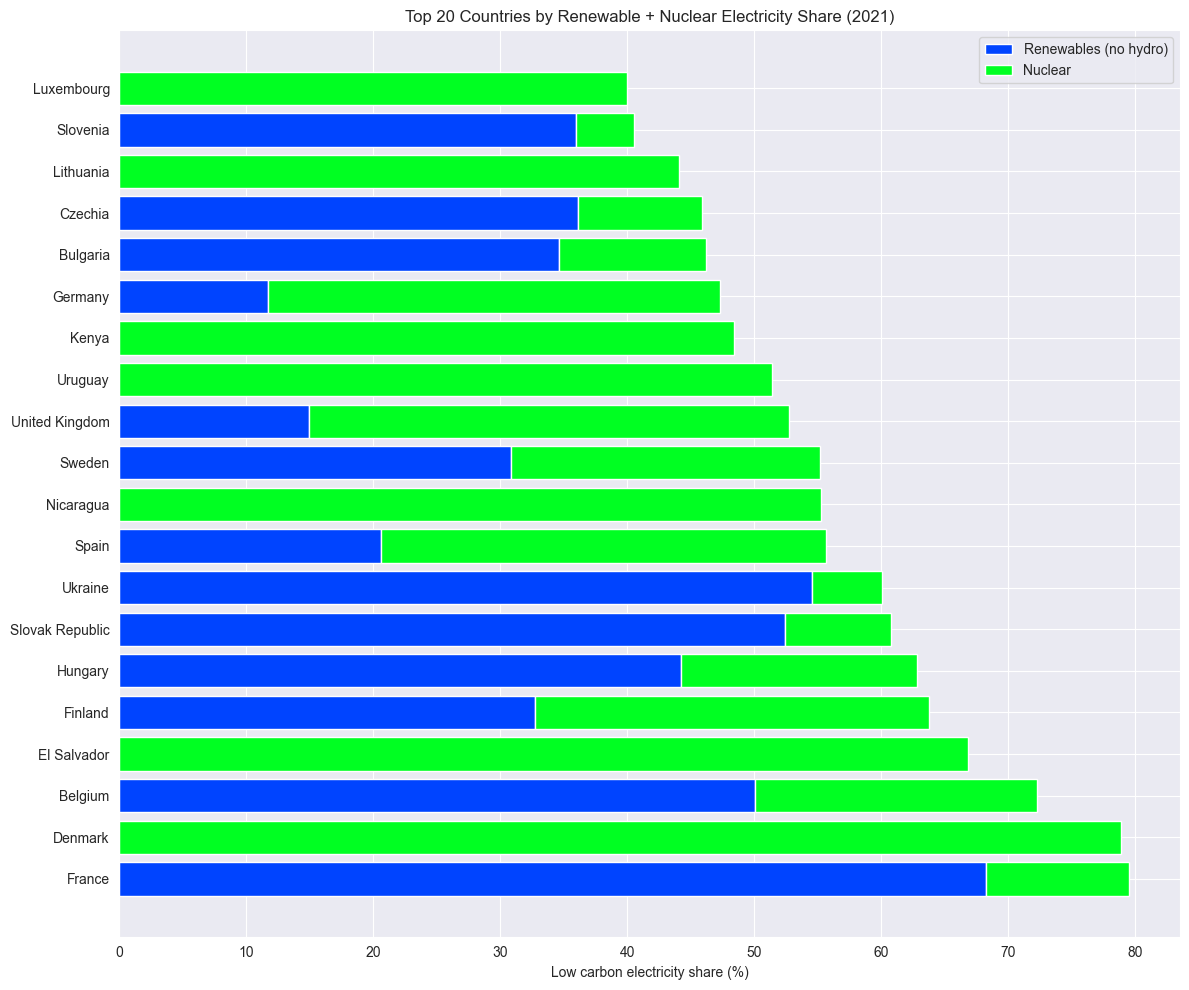

In [9]:
# --- Prepare data ---
top20 = (
    snapshot[["name", "renewable_electricity_share_nohydro", "nuclear_electricity_share"]]
    .dropna()
    .assign(
        name=lambda df: df["name"].astype(str),  # Force name as strings
        renew=lambda df: df["renewable_electricity_share_nohydro"].astype(float),
        nuc=lambda df: df["nuclear_electricity_share"].astype(float),
        total=lambda df: df["renew"] + df["nuc"]
    )
    .sort_values("total", ascending=False) # Selecting ony the top 20
    .head(20)
)

# --- Extract stacks ---
countries = top20["name"]
renew = top20["renew"]
nuc = top20["nuc"]

# --- Plot ---
plt.figure(figsize=(12, 10))

countries = top20["name"]
renew = top20["renewable_electricity_share_nohydro"]
nuclear = top20["nuclear_electricity_share"]

# --- Stacked bar chart ---
plt.barh(
    y=countries,
    width=nuclear,
    color="#0044FF",
    label="Renewables (no hydro)"
)

plt.barh(
    y=countries,
    width=renew,
    left=nuclear,
    color="#00FF22",
    label="Nuclear"
)

plt.xlabel("Low carbon electricity share (%)")
plt.title("Top 20 Countries by Renewable + Nuclear Electricity Share (2021)")
plt.legend()
plt.tight_layout()
plt.show()